<h1><center>Determining Land Ownership Based on Geometry</center></h1>
<h3><center>Machine Learning I (DATS 6202), Spring 2019, Professor Yuxiao Huang</center></h3>
<h3><center>Nathan Justice - Final Project, Team 6</center></h3>
<h4><center>April 29th, 2019</center></h4>
<hr/>

# Introduction

Before leaving my hometown to enroll in this program I met with the Director of Engineering at onX, a company I aspire to work for. The flagship product at onX is a highly praised hunting app specializing in the delivery of offline land ownership maps to mobile devices. During our meeting the director went over a handful of obstacles the company is facing with further innovating their product, problems they suspect a data scientist could be well equipped to handle. The most interesting challenge to me was the issue of determining land ownership based on spatial polygon geometry. 

OnX makes a GPS mapping tool for hunters and outdoorsman. One of the many features
available is administrative GIS layering, where the user can identify what type of land they are in based
on their location. According to the folks at onX, two of their biggest challenges with this feature relate to
data integration and data resolution. In order to build these layers, the onX team has to aggregate GIS data
from an extraordinary number of different sources, ranging from federal to municipal management,
across the entire country. Often two given datasets are too disparate to be easily merged.

A possible solution to their data integration problem is to build a classification model to predict
the type of land (in this case the level of land ownership) based on the shape of the administrative
boundary defining it. For example, I hypothesized that private and block management land typically have a more box-like shape
because they’re defined by arbitrary decision-making. Whereas the shape of other ownership
types like National Forests (belonging to the Federal Government) are defined by aspects of the
landscape itself and therefore have generally more ambiguous shapes.

The goal of this project was to develop a classification system that can identify land ownership of spatial polygons based on their geometry, without incorporating any information related to their source, geographic position, or descriptive attributes. 

<strong>For the sake of limited time and computing power, I elected to focus on data related only to Montana and narrow the classification to two labels - 1 if the polygon is owned by the U.S. Bureau of Land Management and 0 otherwise.</strong>

The U.S. Bureau of Land Management is of interest because they are the federal agency in charge of managing public land across the country, a responsibility of great interest to the types of users onX attracts.
<hr/>

# Experiment

This section describes, in text and code, the methodology behind the project.

The first step was to setup the working environment and collect data from the Montana MSDI Cadastral FTP server ( ftp://ftp.geoinfo.msl.mt.gov/ ). 

In [2]:
# import dependencies
import urllib
import zipfile
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import seaborn as sns
from descartes import PolygonPatch
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### Fetching County Parcel Data

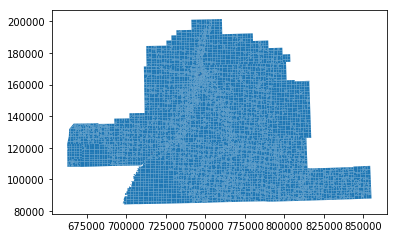

In [5]:
# load and clean list of county names
countyList = open('Data/CountyList.txt', 'r+')
countyList = countyList.read().split('\n')
countyList = [i.replace(" ", "").lower().capitalize() for i in countyList]

# limit the number of counties to include for resource purposes
countyList = [countyList[1]]

# initialize the base ftp url
base = 'ftp://ftp.geoinfo.msl.mt.gov/Data/Spatial/MSDI/Cadastral/Parcels/'

# make requests for parcel data for each county in the list
for i in countyList:
    url = base + i + '/' + i + 'OwnerParcel_shp.zip'
    res = urllib.request.urlopen(url).read()

    with open('Data/Parcels/' + i + '.zip', 'wb') as f:
        f.write(res)
    f.close()

# unzip the downloaded data
for i in countyList:
    zip_ref = zipfile.ZipFile('Data/Parcels/' + i + '.zip', 'r')
    zip_ref.extractall('Data/Parcels/' + i)
    zip_ref.close()

# load new data and populate storage object for parcels
parcels = {}
base = 'Data/Parcels/'

for i in countyList:
    path = base + i + '/' + i + 'OwnerParcel_shp.shp'
    parcels[i] = gpd.read_file(path)

parcels[countyList[0]].plot()

### Fetching Public Lands Data

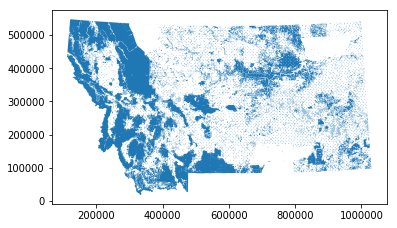

In [7]:
# make request for public lands data
res = urllib.request.urlopen('ftp://ftp.geoinfo.msl.mt.gov/Data/Spatial/MSDI/Cadastral/PublicLands/MTPublicLands_SHP.zip').read()

with open('Data/PublicLands/PublicLands.zip', 'wb') as f:
    f.write(res)
f.close()

# unzip the downloaded data
zip_ref = zipfile.ZipFile('Data/PublicLands/PublicLands.zip', 'r')
zip_ref.extractall('Data/PublicLands/PublicLands')
zip_ref.close()

# load the new data
publicLands = gpd.read_file('Data/PublicLands/PublicLands/MTPublicLands_SHP.shp')

# make a copy of the public lands data so later cells can be re-run independently
publicLandsCopy = publicLands

publicLands.plot()

### Fetching Conservation Easement Data

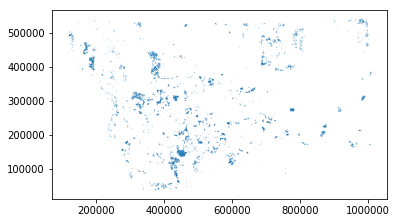

In [8]:
# make request for easement data
res = urllib.request.urlopen('ftp://ftp.geoinfo.msl.mt.gov/Data/Spatial/MSDI/Cadastral/ConservationEasements/MTConEasements_SHP.zip').read()

with open('Data/ConservationEasement/ConservationEasement.zip', 'wb') as f:
    f.write(res)
f.close()

# unzip the downloaded data
zip_ref = zipfile.ZipFile('Data/ConservationEasement/ConservationEasement.zip', 'r')
zip_ref.extractall('Data/ConservationEasement/ConservationEasement')
zip_ref.close()

# load the new data
conservationEasement = gpd.read_file('Data/ConservationEasement/ConservationEasement/MTConEasements_SHP.shp')

conservationEasement.plot()

### Fetching Administrative Boundaries Data

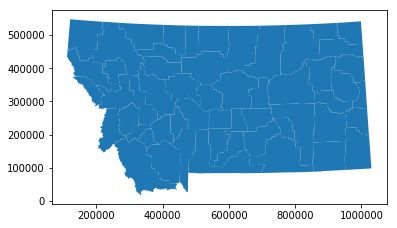

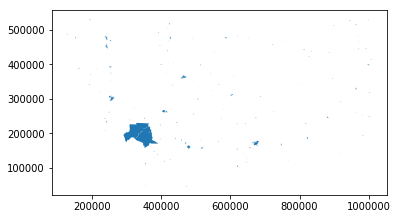

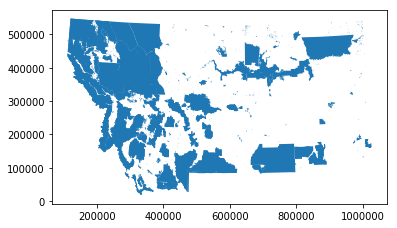

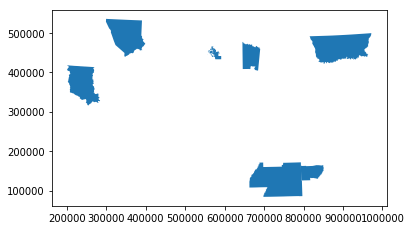

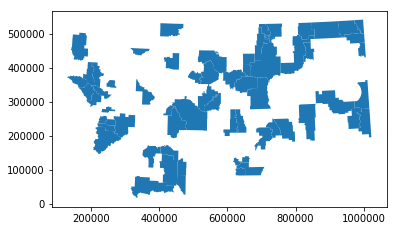

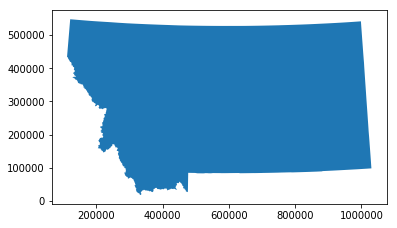

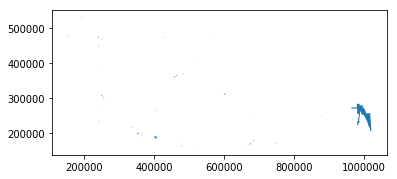

In [11]:
# load and clean list of administrative boundary types
adminBoundaryList = open('Data/AdminBoundaryList.txt', 'r+')
adminBoundaryList = adminBoundaryList.read().split('\n')

# initialize the base ftp url
base = 'ftp://ftp.geoinfo.msl.mt.gov/Data/Spatial/MSDI/AdministrativeBoundaries/'

# make requests for administrative data for each type in the list
for i in adminBoundaryList:
    url = base + 'Montana' + i + '_shp.zip'
    res = urllib.request.urlopen(url).read()

    with open('Data/AdministrativeBoundaries/' + i + '.zip', 'wb') as f:
        f.write(res)
    f.close()

# unzip the downloaded data
for i in adminBoundaryList:
    zip_ref = zipfile.ZipFile('Data/AdministrativeBoundaries/' + i + '.zip', 'r')
    zip_ref.extractall('Data/AdministrativeBoundaries/' + i)
    zip_ref.close()

# load new data and populate storage object for parcels
adminBoundaries = {}
base = 'Data/AdministrativeBoundaries/'

adminBoundaries['Counties'] = gpd.read_file(base + 'Counties/MontanaCounties_shp/County.shp')
adminBoundaries['IncorporatedCitiesTowns'] = gpd.read_file(base + 'IncorporatedCitiesTowns/MontanaIncorporatedCitiesTowns_shp/MontanaIncorporatedCitiesTowns.shp')
adminBoundaries['ManagedAreas'] = gpd.read_file(base + 'ManagedAreas/MontanaManagedAreas.shp')
adminBoundaries['Reservations'] = gpd.read_file(base + 'Reservations/MontanaReservations_shp/MontanaReservations.shp')
adminBoundaries['SchoolDistricts'] = gpd.read_file(base + 'SchoolDistricts/MontanaSchoolDistricts_shp/Unified.shp')
adminBoundaries['StateBoundary'] = gpd.read_file(base + 'StateBoundary/MontanaStateBoundary_shp/StateofMontana.shp')
adminBoundaries['TIFDs'] = gpd.read_file(base + 'TIFDs/MontanaTIFDs_shp/TIFD.shp')
adminBoundaries['WeedDistricts'] = gpd.read_file(base + 'WeedDistricts/MontanaWeedDistricts_shp/MontanaWeedDistricts.shp')

# make a copy of the managed areas data so later cells can be re-run independently
managedAreasCopy = adminBoundaries['ManagedAreas']

adminBoundaries['Counties'].plot()
adminBoundaries['IncorporatedCitiesTowns'].plot()
adminBoundaries['ManagedAreas'].plot()
adminBoundaries['Reservations'].plot()
adminBoundaries['SchoolDistricts'].plot()
adminBoundaries['StateBoundary'].plot()
adminBoundaries['TIFDs'].plot()

### Fetching National Park Service Administrative Boundaries

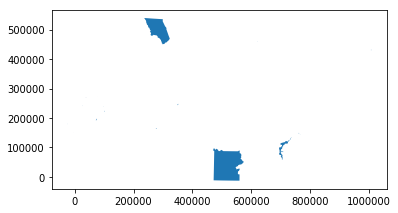

In [12]:
# make request for easement data
res = urllib.request.urlopen('http://ftp.geoinfo.msl.mt.gov/Data/Spatial/MSDI/AdministrativeBoundaries/NationalParkServiceAdminBoundaries_shp.zip').read()

with open('Data/NationalParkServiceAdmin/NationalParkServiceAdminBoundaries_shp.zip', 'wb') as f:
    f.write(res)
f.close()

# unzip the downloaded data
zip_ref = zipfile.ZipFile('Data/NationalParkServiceAdmin/NationalParkServiceAdminBoundaries_shp.zip', 'r')
zip_ref.extractall('Data/NationalParkServiceAdmin/')
zip_ref.close()

# load the new data
npsAdmin = gpd.read_file('Data/NationalParkServiceAdmin/NationalParkServiceAdminBoundaries_shp/NationalParkServiceAdminBoundaries_Montana.shp')

npsAdmin.plot()

### Helpers for Building Model Inputs Table

Now that the data has been collected, the next step was to build a dataframe to feed into the modeling and analysis section.

In [106]:
# purpose: checks if shapely object is a Polygon or MultiPolygon
# input: a Polygon or MultiPolygon object
# output: 1 if parameter is a MultiPolygon and 0 otherwise
def isMultiPolygon(poly):
    if poly.type == 'MultiPolygon':
        return 1
    else:
        return 0

# purpose: extract the exterior and interior coordinates of the points defining a polygon
# input: a Polygon or MultiPolygon object
# output: dictionary of lists for exterior and interior point coordinates
def fetchPolygonCoords(poly):
    if isMultiPolygon(poly) == 0:
        exterior = poly.exterior.coords[:]
        interior = []

        for i in poly.interiors:
            interior += i.coords[:]
    else:
        exterior = []
        interior = []

        for i in poly:
            fpc = fetchPolygonCoords(i)
            exterior += fpc['exterior']
            interior += fpc['interior']

    return {'exterior': exterior, 'interior': interior}

# purpose: count the number of exterior and interior coordinates of the points defining a polygon
# input: a Polygon or MultiPolygon object
# output: tuple of the number of exterior and interior points
def countCoordinates(poly):
    coords = fetchPolygonCoords(poly)

    return (len(coords['exterior']), len(coords['interior']))



### Building Model Inputs Table

In [107]:
#################################################################################
# "True" Target Labels = 1
#################################################################################

# initialize storage object for the model inputs table
inputs = {'BLM': [], 'Area': [], 'Perimeter': [], 'Exterior Coords': [],
          'MultiPolygon': [], 'Interior Coords': [], 'Convex Hull Dist': []}

# purpose: populate the model inputs storage object with the appropriate feature values derived from the polygons composing
    # the various input datasets
# input: GeoDataFrame to have features extracted from, value for the target label (1 = entity of interest), 
    # column label for the shape attribute, column label for the perimeter attribute
# output: NULL - side-effect of populating the model inputs table
def buildModelInputs(df, target, area, perimeter):
    for i in range(df.shape[0]):
        coords = countCoordinates(df.loc[i, 'geometry'])
        convexHull = df.loc[i, 'geometry'].convex_hull
        maxHull = max(convexHull.bounds)
        minHull = min(convexHull.bounds)

        # set the target label to 1
        inputs['BLM'].append(target)
        inputs['Area'].append(df.loc[i, area])
        inputs['Perimeter'].append(df.loc[i, perimeter])
        inputs['Exterior Coords'].append(coords[0])
        inputs['MultiPolygon'].append(isMultiPolygon(df.loc[i, 'geometry']))
        inputs['Interior Coords'].append(coords[1])
        inputs['Convex Hull Dist'].append(maxHull - minHull)

# subset managed areas polygons owned by the entity of interest
blm1 = managedAreasCopy[managedAreasCopy['INST'] == 'US Bureau of Land Management']
blm1.reset_index(drop=True, inplace=True)
# replace the managed areas data with a copy except for the entity of interest
managedAreas =  managedAreasCopy[managedAreasCopy['INST'] != 'US Bureau of Land Management']
managedAreas.reset_index(drop=True, inplace=True)
adminBoundaries['ManagedAreas'] = managedAreas

# subset public lands polygons owned
blm2 = publicLandsCopy[publicLandsCopy['OWNER'] == 11]
blm2.reset_index(drop=True, inplace=True)
# replace the public lands data with a copy except for the entity of interest
publicLands = publicLandsCopy[publicLandsCopy['OWNER'] != 11]
publicLands.reset_index(drop=True, inplace=True)

# append records of polygons owned by the entity of interest to the model inputs table
buildModelInputs(blm1, 1, 'Shape_Area', 'Shape_Leng')
buildModelInputs(blm2, 1, 'Shape_STAr', 'Shape_STLe')

#################################################################################
# "False" Target Labels = 0
#################################################################################

# append records of polygons not owned by the entity of interest to the model inputs table
buildModelInputs(adminBoundaries['ManagedAreas'], 0, 'Shape_Area', 'Shape_Leng')
buildModelInputs(publicLands, 0, 'Shape_STAr', 'Shape_STLe')
buildModelInputs(adminBoundaries['Counties'], 0, 'Shape_Area', 'Shape_Leng')
buildModelInputs(adminBoundaries['IncorporatedCitiesTowns'], 0, 'Shape_Area', 'Shape_Leng')
buildModelInputs(adminBoundaries['Reservations'], 0, 'SHAPE_Area', 'SHAPE_Leng')
buildModelInputs(adminBoundaries['SchoolDistricts'], 0, 'SHAPE_Area', 'SHAPE_Leng')
buildModelInputs(adminBoundaries['StateBoundary'], 0, 'SHAPE_Area', 'SHAPE_Leng')
buildModelInputs(adminBoundaries['TIFDs'], 0, 'SHAPE_Area', 'SHAPE_Leng')
buildModelInputs(conservationEasement, 0, 'Shape_STAr', 'Shape_STLe')
buildModelInputs(npsAdmin, 0, 'Shape_Area', 'Shape_Leng')

# loop through all counties in the list and append the polygons to the model inputs table
for i in countyList:
    buildModelInputs(parcels[i], 0, 'SHAPE_Area', 'SHAPE_Leng')

# convert the model inputs storage object into a dataframe
inputs = pd.DataFrame(inputs)


print(inputs.shape)
print(inputs.head())

(46463, 7)
   BLM          Area     Perimeter  Exterior Coords  MultiPolygon  \
0    1  7.542153e+06  21313.075238               77             1   
1    1  3.617842e+07  38572.384836              253             0   
2    1  2.344097e+05   2463.308321               14             0   
3    1  1.372398e+08  65448.005605              476             0   
4    1  1.617515e+05   1608.734057                5             0   

   Interior Coords  Convex Hull Dist  
0                0        45922.8425  
1                0       189929.2663  
2                0       521696.9504  
3                0       616608.5590  
4                0       437863.4325  


### Description of Model Inputs Table

<ul>
<li>
<em>BLM</em>
- target column where a value of 1 indicates the polygon is owned by the U.S. Bureau of Land Management and a value of 0 indicates the polygon is owned by anyone else
</li>
<li>
<em>Area</em>
- the area of the polygon in square meters
</li>
<li>
<em>Perimeter</em>
- the perimeter of the polygon in meters
</li>
<li>
<em>Exterior Coords</em>
- the number of exterior coordinates defining the outer shape(s) of the polygon
</li>
<li>
<em>MultiPolygon</em>
- boolean value where a value of 1 indicates the polygon is of MultiPolygon type (has interior coordinates) and a value of 0 indicates the polygon is of Polygon type (does not have interior coordinates)
</li>
<li>
<em>Interior Coords</em>
- the number of interior coordinates defining the inner shape(s) of the polygon
</li>
<li>
<em>Convex Hull Dist</em>
- the maximum distance across the convex shape containing all the exterior points of the polygon
</li>
</ul>

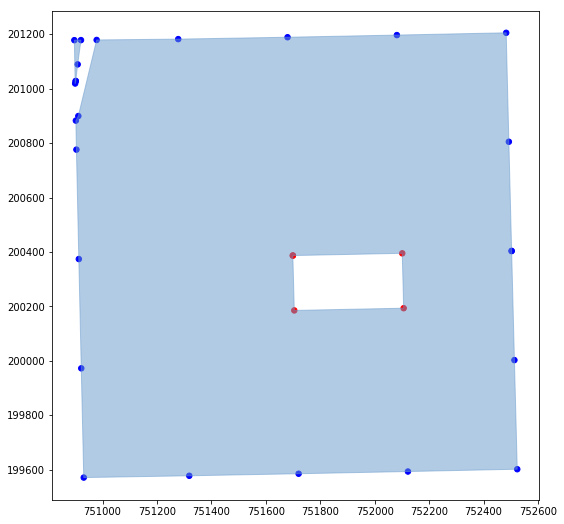

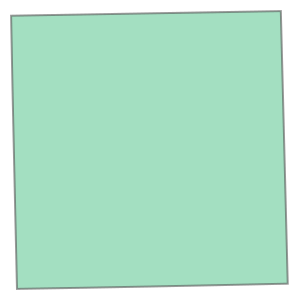

In [108]:
#################################################################################
# example of model inputs features
#################################################################################

# blue shape(s) = the polygon record
# blue points = the exterior coordinates
# red points = the interior coordinates of a MultiPolygon
# green shape in second figure = convex hull

geo = parcels[countyList[0]]['geometry'][5]
coords = fetchPolygonCoords(geo)

fig = plt.figure(figsize=(16, 9)) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(geo, fc='#6699cc', ec='#6699cc', alpha=0.5, zorder=2 ))
ax.axis('scaled')

for i in coords['exterior']:
    ax.add_patch(plt.Circle(i, 10, color='blue'))
for i in coords['interior']:
    ax.add_patch(plt.Circle(i, 10, color='red'))

plt.show()

geo.convex_hull

### Modeling - Logistic Regression and K-Fold Cross-Validation

Now that the inputs table has been built, the next step was to undergo the model development process.

Logistic Regression accuracy: 0.557
Logistic Regression ROC AUC: 0.608
Logistic Regression average score: 0.17
Logistic Regression std score of the accuracy: 0.133


Text(0.5, 24.0, 'Predicted label')

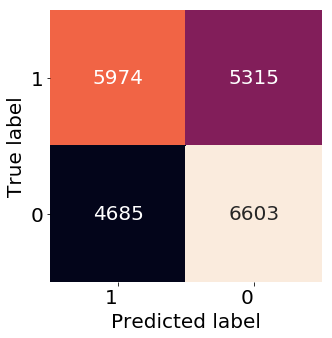

In [109]:
# initialize the feature and target data
X = inputs.drop(columns=['BLM'])
y = inputs['BLM']

# store the feature names
featureNames = X.columns

# handle over sampling
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

# assign 70-30% train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# build logistic regression pipeline with standard scaler for standardization
pipe_lr = Pipeline([('StandardScaler', StandardScaler()), ('LogisticRegression', LogisticRegression(solver='lbfgs'))])

# fit the model
pipe_lr.fit(X, y)

# predict
y_pred = pipe_lr .predict(X_test)
y_pred_score = pipe_lr .predict_proba(X_test)

# report prediction scores
print('Logistic Regression accuracy:', str(round(accuracy_score(y_test, y_pred), 3)))
print('Logistic Regression ROC AUC:', str(round(roc_auc_score(y_test, y_pred_score[:,1]), 3)))

# perform cross validation to get average score across 10 folds
accs = cross_val_score(pipe_lr, X, y, cv=KFold(n_splits=10, random_state=0))

print('Logistic Regression average score:', round(accs.mean(), 3))
print('Logistic Regression std score of the accuracy:', round(accs.std(), 3))

# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = inputs['BLM'].unique()

df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(5,5))

hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20},
  yticklabels=df_cm.columns, xticklabels=df_cm.columns)

hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)

plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)

### Modeling - Model Selection (Logistic, DT, RF, and KNN)

<strong>NOTE:</strong> The follow section of code takes <em>heavily</em> from Exercise 7.

In [110]:
# initialize dictionary of classifiers
clfs = {'lr': LogisticRegression(random_state=0), 'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0), 'knn': KNeighborsClassifier()}

# initialize pipeline map
pipe_clfs = {}

# populate dictionary of pipelines
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

# initialize dictionary for parameter grids
param_grids = {}

# populate parameter grid for logistic regression
C_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

param_grids['lr'] = param_grid

# populate parameter grid for decision tree
param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['dt'] = param_grid

# populate parameter grid for random forest
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid

# populate paramter grid for k-nearest neighbor
param_grid = [{'clf__n_neighbors': list(range(1, 11))}]

param_grids['knn'] = param_grid

# initialize storeage for best scores
best_score_param_estimators = []

# loop through parameters, apply grid search parameter tuning and cross validation
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name], param_grid=param_grids[name], scoring='accuracy', n_jobs=-1,
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

    # fit the model in focus
    gs = gs.fit(X, y)
    
    # add the scores
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

# preview the results
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n') 

[0.9396194323376209, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.9266503667481663, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}, <class 'sklearn.tree.tree.DecisionTreeClassifier'>]

[0.9243781226746041, {'clf__n_neighbors': 1}, <class 'sklearn.neighbors.classification.KNeighborsClassifier'>]

[0.5630514510470926, {'clf__C': 0.1, 'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg'}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]



<hr/>

# Conclusions

The results of the logistic regression were exceptionally poor, with an accuracy and ROC AUC score of only 0.557 and 0.608, respectively. The cross-validated logistic regression across 10 folds also yielded dismal results, with an average score of only 0.170 and a formidable standard deviation of 0.133.

However, the results of the model selection process with logistic regression, decision tree, random forest, and k-nearest neighbors cross-validated across 5 folds and hyperparameters tuned via grid search provided much more encouraging results. The logistic regression score was as low as when run outside of the tuning process, but the new random forest, decision tree, and k-nearest neighbor models all achieved accuracy scores above 0.92. 

The best cross-validated, tuned model was the random forest classifier with the minimum leaf hyperparameter set to 1, minimum sample split set to 2, and the number of estimators set to 30. Together this combination had an accuracy of 0.94.

At first I was worried because my default is to always start with a logistic regression because it’s what I’m most familiar with, and those results were not promising. After going through a proper model selection process, it became clearer as to why logistic regression performed so poorly. When thinking carefully about the meaning of the features in the input dataset, it’s difficult to imagine how a linearly separable relationship could be drawn between them. Although there are only a few features available, their nuance pushes beyond the appropriate assumptions and expectations of logistic regression. The other three models make more sense because they’re better suited to consider how the features describe the shape and appearance of the polygons. In this case it seems to be a matter of finding the right class of models that fit the data. If time was more in my favor, I’d like to include other models with linearity assumptions like support vector classifier to see if it would score more closely to the logistic regression. Additionally, the model selection process should have at least 10 splits in the cross validation folding. 

The most challenging aspect of this project has been trying to figure out ways to extract features from a polygon without using any spatial properties. If spatial characteristics were available, there would be an endless supply of features I could include in the input dataset but doing so would defeat the whole premise of the project – to use only the geometry of the shape and ignore all aspects of a polygons position in space.
Even though the random forest classifier scored well, I do not think it is truly the best type of model for this problem. Many times, I found myself investigating potential features to include, only to be shut down by the realization that they would require features composed of complex, nested objects. For example, I think the best way to describe the shape of a polygon would be to decompose it into an array of line segments. An array with less segments would represent a more rectangular polygon and longer segment lengths would correspond to larger polygons. However, I have not yet learned how to implement models with feature values composed of arrays and nested arrays.
<a href=”https://arxiv.org/pdf/1806.03857.pdf”>From my research I found one particular paper where they did essentially the same project but with building footprints instead of administrative boundaries.</a> In this paper they used convoluted neural networks for their classification system. I saw many other polygon-identification-related papers also using this framework. From my quick skimming, it seems to be a good fit for this type of project because the model allows the extraction of spatially-related information without putting the polygon in actual space (pseudo-, meaningless space if you will). Interestingly, the convoluted neural network used in the paper does rely on nested arrays as feature values, which is in alignment with what I’ve been thinking about while developing this project. I look forward to learning more about neural networks and potentially opportunities to return to this type of problem.

Before the presentation, I intend on adding a couple more models to the selection process, adding more parameter values, and increasing the cross-validation folds. Unfortunately, this is the most my computer can handle with the impending deadline. Additionally, adding more data from both inside and outside the state of Montana would be beneficial. 

In summary, although a bit more tweaking is in order, I believe I am well on my way to developing a classification system that can accurately determine whether or not a polygon in the state of Montana is owned by the U.S. Bureau of Land Management based on it's geometry.